# Companion code for "Persistent homology based computed tomography measurements of fibrosis and emphysema in lung diseases"

- Input data file: volume data should be prepared in the dicom format or the numpy format (.npz)
-- the npz file should be placed under the directory specified by root_npy
-- the dicom series should be placed under a single directory under the directory specified by root_npy

In [ ]:
#install necessary packages only if you do not have them yet
!pip install persim ipywidgets
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim

In [1]:
## This program requires a lot of (GPU) memory.
## Restart the kernel when you get "out of memory" errors.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import os,time,subprocess,glob,re,pandas
from scipy.ndimage.filters import convolve
import ipywidgets as ipyw
import seaborn as sns
from lung_whole_batch import *
np.set_printoptions(precision=5,suppress=True)


## Setting

In [6]:
## characteristic cycles
# cycles of 'dim' with birth time between b0 through b1, death time between d0 through d1, lifetime between l0 through l1 will be counted
# and those voxels with density higher than th will be visualized
cond = [
         {'name': 'fib', 'dim': 0, 'b0':-1260, 'b1':-380, 'd0': -5000, 'd1': 5000, 'l0': 360, 'l1': 5000, 'th': 1}, 
         {'name': 'emp', 'dim': 2, 'b0':-1020, 'b1':-900, 'd0': -5000, 'd1': 5000, 'l0': 20, 'l1': 90, 'th': 8.3},
       ]

th_def = [f['th'] for f in cond]

## GPU
gpu_id = 0 ## use the first gpu on the system
#gpu_id = -1   ## in case you do not have GPU

## the directory containing all data files
root_npy = os.path.expanduser("~/ipf/npy/")

## filename and the z-slice to be focused
name, init_z="PD20813300segmentedfinal", 381
#name, init_z="R135000_009", 0

## labelling (optional)
data_fn = "idlist.csv"
if os.path.isfile(data_fn):
    dat = pandas.read_csv(data_fn,header=0)
    names = dat['name'].tolist()
    label = dat.at[names.index(name),'label']
else:
    label = "unknown"

## gaussian kernel parameter
sigma, h = 10.0, 12

## filename for cache for cycle_norm 
# change this everytime you change either sigma, h, cond
cycle_data_suffix = "_cyc200930.npz"

## focus on a spefic z-range for efficiency
#z_crop = (init_z-2*h, init_z+2*h)
z_crop = None   # process the whole volume

## flag to recompute characteristic cycles based on "cond"
recompute_cycle_norm = False

print("characteristic cycles: ",cond)
if not os.path.isdir(root_npy):
    print("set root_npy correctly!")
print("npy dir: ",root_npy)


characteristic cycles:  [{'name': 'fib', 'dim': 0, 'b0': -1260, 'b1': -380, 'd0': -5000, 'd1': 5000, 'l0': 360, 'l1': 5000, 'th': 1}, {'name': 'emp', 'dim': 2, 'b0': -1020, 'b1': -900, 'd0': -5000, 'd1': 5000, 'l0': 20, 'l1': 90, 'th': 8.3}]
npy dir:  /home/skaji/ipf/npy/


## Main

In [3]:
## load/compute volume (vol), persistent homology (pd), cycle density (cycle_norm)
## results will be cached under root_npy. remove the cache files if you want to recompute.

print("loading... {}, label {}, z_crop {}".format(name, label, z_crop))
base_fn = os.path.join(root_npy,name)

# load volume from a cached npz file. If not present, load from DICOM files and save to a npz file
vol = load_vol(base_fn+".npz",z_crop=z_crop, save_npz=True)
# load persistet diagram from a cached npz file. If not present, compute from the volume and save to a npz file
pd = load_pd(base_fn,vol=vol,z_crop=z_crop)
# load segmented volume for comparison (optional)
nn_vol = load_vol(base_fn+"_NN1.npz",z_crop=z_crop)
if nn_vol is None:
    nn_vol = np.zeros_like(vol)
else:
    nn_vol = nn_vol.astype(np.float32)
print("Volume: ",vol.shape," PD: ",pd.shape)

# compute cycle norm (density of characteristic cycles specified by 'cond')
# the result will be saved in the file "*+cycle_data_suffix".
# cycle norm should be recomputed everytime any of 'cond', 'h', 'sigma' is changed.
recompute_data = {'vol': vol, 'pd': pd, 'cond': cond, 'h':h, 'sigma':sigma, 'gpu_id': gpu_id, 'force': recompute_cycle_norm}
cycle_norm = load_cyc(base_fn+cycle_data_suffix,recompute=recompute_data,z_crop=z_crop,verbose=True)

# print some statistics
stats = volume_stat(vol,cycle_norm, th_def)
st = ["vol",cond[0]['name'],cond[1]['name'],cond[0]['name']+"_ratio",cond[1]['name']+"_ratio",cond[0]['name']+"_99%",cond[1]['name']+"_99%",
      cond[0]['name']+"%>th",cond[1]['name']+"%>th","HAA%","LAA%"]
for s,ff in zip(st,stats):
    print(s,"\t\t",ff)
    
#stats = volume_stat(vol,nn_vol, [0.5,0.5])
#st = ["fib_NN_ratio","emp_NN_ratio","fib_NN_99%","fib_NN_99%","emp_NN%>0.5","emp_NN%>0.5"]
#for s,ff in zip(st,stats[3:-2]):
#    print(s,"\t\t",ff)


loading... PD20813300segmentedfinal, label unknown, z_crop None
Volume:  (512, 512, 690)  PD:  (4315806, 6)
pre-computed cycle heatmap loaded
elapsed_time:3.9386258125305176 sec
vol 		 18737364.0
fib 		 14745228.0
emp 		 183085800.0
fib_ratio 		 0.7869425
emp_ratio 		 9.77116
fib_99% 		 10.27529
emp_99% 		 133.82753
fib%>th 		 0.17740697
emp%>th 		 0.15857199
HAA% 		 0.045857303
LAA% 		 0.23336089


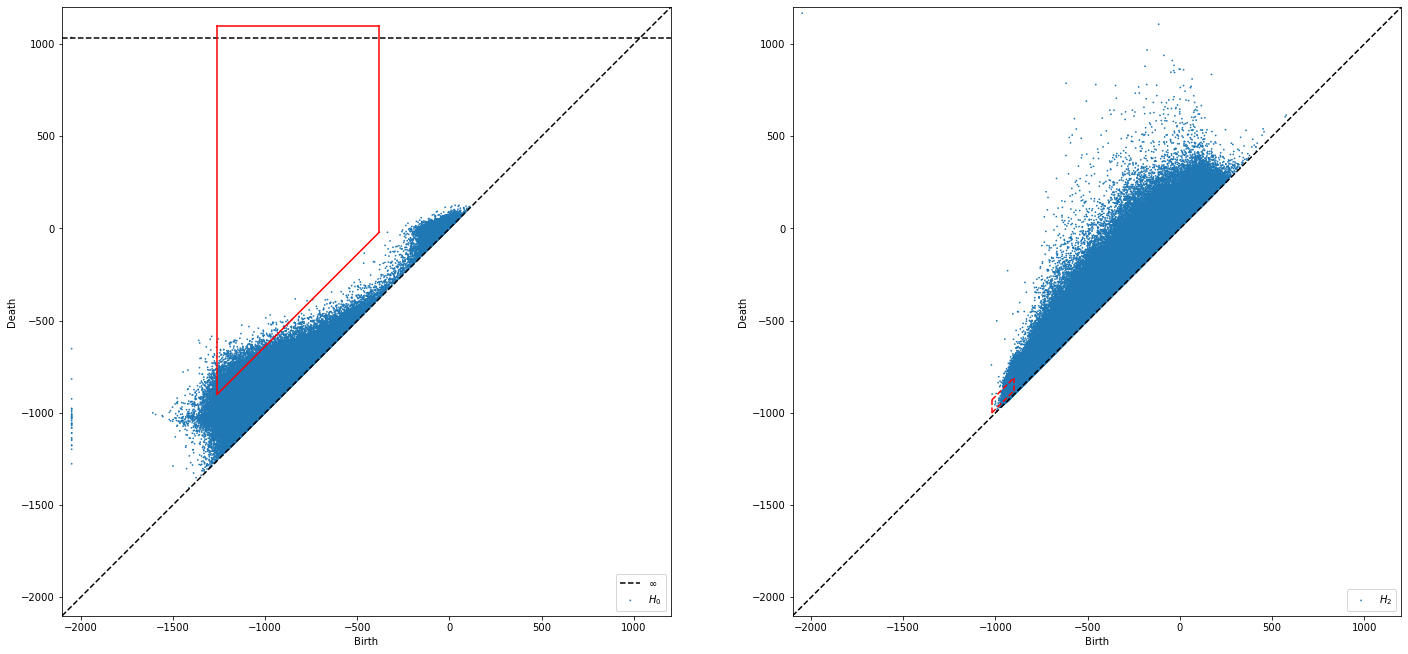

In [4]:
# persistence diagram
PDView(pd,cond,save_fn="PD_"+name+".jpg")
#PDView(pd,cond,zmin=init_z-20,zmax=init_z+20)

In [7]:
# visualise pixels above/below threshold values (overlay)
print(name,label)    
red,blue = 500, 1000
th_nn = [0.5,0.5]

th = th_def

if z_crop:
    zz = (z_crop[1]-z_crop[0])//2
else:
    zz = init_z

_ = ImageSliceViewer3D([ np.stack([vol,vol,vol]), # original CT
                    np.stack([vol+red*(cycle_norm[0]>th[0]),vol,vol+blue*(cycle_norm[1]>th[1])*(cycle_norm[0]<=th[0])]),  # PH
                    np.stack([vol+red*(nn_vol[0]>th_nn[0]),vol,vol+blue*(nn_vol[1]>th_nn[1])]), ## NN
                    np.stack([vol+red*(vol>-200),vol,vol+blue*(-2048<vol)*(vol<-950)]), ## LAA/HAA
                   ],colour=True,
                   title=["CT","PH","NN","AA"],
                   init_z=zz, vmin=[-1000],vmax=[500],save="{}_z{}.jpg".format(name,init_z)
                      )

PD20813300segmentedfinal CPFE


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [ ]:
# visualise a single slice
th = th_def

print(name,label, "z={}".format(init_z))    
if z_crop:
    zz = (z_crop[1]-z_crop[0])//2
else:
    zz = init_z

v=vol[:,:,[zz]]
_ = ImageSliceViewer3D([np.stack([v,v,v]),
                    np.stack([v+red*(cycle_norm[0,:,:,zz:(zz+1)]>th[0]),v,v+blue*(cycle_norm[1,:,:,zz:(zz+1)]>th[1])*(cycle_norm[0,:,:,zz:(zz+1)]<=th[0])]),
                    np.stack([v+red*(v>-200),v,v+blue*(-2048<v)*(v<-950)]),
                   ], title=["CT","PH","AA"],
                   vmin=[-1000],vmax=[500],colour=True)

In [ ]:
# visualise pixels above/below threshold values (replace)
base_vol = (np.clip(np.stack([vol,vol,vol]),-1000,500)+1000)/1500
PHmarked_vol = np.stack([cycle_norm[0]>th[0],np.zeros_like(cycle_norm[0]),cycle_norm[1]>th[1]])
PHmarked_vol = np.where(np.max(PHmarked_vol,axis=0)>0, PHmarked_vol, base_vol)
HUmarked_vol = np.stack([vol>-200,np.zeros_like(cycle_norm[0]),np.logical_and(-2048<vol,vol<-950)])
HUmarked_vol = np.where(np.max(HUmarked_vol,axis=0)>0, HUmarked_vol, base_vol)

_ = ImageSliceViewer3D([base_vol,PHmarked_vol,HUmarked_vol],init_z=init_z, colour=True)


In [ ]:
# visualise pixel values (separately)
# set vmin and vmax for viewing level window
# choose cmap from https://matplotlib.org/examples/color/colormaps_reference.html
_ = ImageSliceViewer3D([vol,cycle_norm[0],cycle_norm[1]],vmin=[-1000,0,0,0],title=["CT","fib","emp"],
                       init_z=init_z,cmap=['gray','Reds','Reds'])

99 percentile:  10.275289878845214
99 percentile:  133.82752990722656


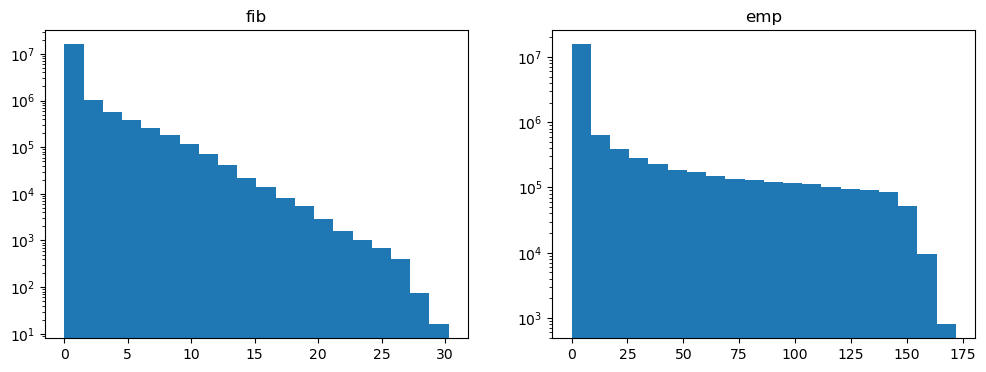

In [8]:
# histgram of cycle density
in_cycle = cycle_norm[:,vol>-2048]
plt.figure(figsize=(12,4))
for i,a in enumerate(in_cycle):
    ax = plt.subplot(1,len(in_cycle),i+1)
    ax.hist(a.flatten(),bins=20, log=True)
    ax.set_title(cond[i]['name'])
    print("99 percentile: ", np.percentile(a, 99))

## Comparison of segmentation

In [ ]:
## visualise and compute DICE for segmentation results
from sklearn.metrics import jaccard_score

root_label ="label_image/testB"
models = ["PH25","PH50","NN1","AA"]
names = [os.path.splitext(os.path.splitext(fname)[0])[0] for fname in sorted(os.listdir(root_label)) if fname.endswith(".npy")]
names = ["IPF144segmentedfinal_405","PD20813300segmentedfinal_382"]  ## for figure in the paper
## computation for DICE
#names = ["IPF030segmentedfinal_438","IPF035segmentedfinal_436","IPF083segmentedfinal_480","IPF109segmentedfinal_457","IPF147segmentedfinal_431","IPF148segmentedfinal_377","IPF153segmentedfinal_474","IPF179segmentedfinal_495","MD003001segmentedfinal_405","MD004202segmentedfinal_485","MD006001segmentedfinal_262","MD006901segmentedfinal_343","PD20613093segmentedfinal_317","PD20813300segmentedfinal_382"]
n_class=3

root_save = "label_image/comparison"
os.makedirs(root_save, exist_ok=True)

th25 = th_def  # ROI25
th50 = [0.4,40]    # ROI50
th_aa = [700,2200] # HAA/LAA
th_nn = [0.5,0.5]  # NN
h, sigma = 12, 10

dices = np.zeros((len(names),15))

for k,fns in enumerate(names):
    print(k,fns)
    fn = fns[:-4]
    init_z = int(fns[-3:])
    z_crop = (init_z-int(1.3*h), init_z+int(1.3*h))
    zz = (z_crop[1]-z_crop[0])//2

    save_fn = os.path.join(root_save,"{}_{}.jpg".format(fn,init_z))
    base_fn=os.path.join(root_npy,fn)
    vol = load_vol(base_fn+".npz",z_crop=z_crop)
    pd = load_pd(base_fn,z_crop=z_crop)
    v = vol[:,:,[zz]]
    
    cycle_25 = load_cyc(base_fn+"_cyc200930.npz",z_crop=z_crop)[:,:,:,[zz]]   
    PH25 = np.zeros_like(v)
    PH25[cycle_25[1,:,:]>th25[1]] = 1    
    PH25[cycle_25[0,:,:]>th25[0]] = 2

    cycle_50 = load_cyc(base_fn+"_cyc200922.npz",z_crop=z_crop)[:,:,:,[zz]]
    PH50 = np.zeros_like(v)
    PH50[cycle_50[1,:,:]>th50[1]] = 1    
    PH50[cycle_50[0,:,:]>th50[0]] = 2    
    
    nn_vol = load_vol(base_fn+"_NN1.npz",z_crop=z_crop)[:,:,:,[zz]].astype(np.float32)
    NN1 = np.zeros_like(v)
    NN1[nn_vol[1,:,:]>th_nn[1]] = 1    
    NN1[nn_vol[0,:,:]>th_nn[0]] = 2    

    #NN2 = np.load(os.path.join(root_NN2,fns)+".npy")[:,:,np.newaxis]
    
    kernel = gaussian(h,sigma)
    aa = conv_channel(np.stack([(v>-200),(-2048<v)*(v<-950)]).astype(np.float32), vol, kernel,verbose=False)[:,:,:,[zz]]
    AA = np.zeros_like(v)
    AA[aa[1]>th_aa[1]] = 1    
    AA[aa[0]>th_aa[0]] = 2    
#    AA[(-2048<v)*(v<-950)] = 1
#    AA[(v>-200)] = 2
    
    manual = np.load(os.path.join(root_label,fns)+".npy")[:,:,np.newaxis]        
    
    print("Volume: ",v.shape)

    _ = ImageSliceViewer3D([  #np.stack([v,v,v]),
                        np.stack([v+500*(manual==2),v,v+800*(manual==1)]),                            
                        np.stack([v+500*(PH25==2),v,v+800*(PH25==1)]),
                        np.stack([v+500*(PH50==2),v,v+800*(PH50==1)]),
                        np.stack([v+500*(NN1==2),v,v+800*(NN1==1)]),                            
#                        np.stack([v+500*(NN2==2),v,v+800*(NN2==1)]),                            
                       np.stack([v+500*(AA==2),v,v+800*(AA==1)]),
                       ],
                       title=["Manual"]+models,
                       vmin=[-1000]*8,vmax=[500]*8,
                           figsize=(100,20),colour=True,save=save_fn,save_exit=True)
    if len(names)>3:
        plt.close()
    
    t_label = manual[v>-2048].flatten()
    for i,lb in enumerate([PH25,PH50,NN1,AA]):
        for j in range(n_class):
            dices[k,n_class*i+j] = jaccard_score(t_label==j,lb[v>-2048].flatten()==j)
    print("DICE: ",dices[k])

## write dice scores to file
dic = {'name': names}
k=0
for dn in models:
    for i in range(n_class):
        dic[dn+"_{}".format(i)] = dices[:,k]
        k +=1
df = pandas.DataFrame.from_dict(dic)
df.to_csv("dice_NN.csv",index=False)

## plot dice
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=1.0, hspace=0.6)
for i in range(n_class):
    ax = fig.add_subplot(1, n_class, i+1)
    ax.violinplot([dic[dn+"_{}".format(i)] for dn in models])
    ax.set_xticks([k+1 for k in range(len(models))])
    ax.set_xticklabels(models)
    ax.set_xlabel('Method')
    ax.set_ylabel('DICE for label {}'.format(i))
    ax.set_ylim(0, 1)
plt.savefig("dice.jpg")


## Utility

In [ ]:
## Gaussian kernel visualisation
h, sigma=12, 9.0
g= gaussian(h,sigma)
print(g.shape, g[h,0,h],g[h,h,h],np.sum(g))
mappable = plt.imshow(g[:,:,h])
plt.colorbar(mappable)

In [ ]:
## show memory usage
import psutil 
mem = psutil.virtual_memory() 
print(mem.used/(1024**2),mem.total/(1024**2),mem.available/(1024**2))

## Experimental

In [ ]:
## tensorflow vs cupy
## currently, cupy is much faster

import time
import cupy as cp
from cupyx.scipy.ndimage import convolve

kernel = gaussian(h,sigma)
cc = cycle_count(vol,pd,cond,conv=False)
print(cc.shape)

start = time.time()
cp.cuda.Device(gpu_id).use()
cn2 = np.stack([ cp.asnumpy(convolve(cp.asarray(cc[i]),cp.asarray(kernel))) for i in range(len(cc))])
print(cn2.shape)
print ("elapsed_time:{} sec".format(time.time() - start))

start = time.time()
cn = convolve_tf(cc, kernel)
print(cn.shape)
print ("elapsed_time:{} sec".format(time.time() - start))
print(np.allclose(cn,cn2))
